# 3. Modelo: Naive bayes

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    GridSearchCV, \
                                    StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, \
                            precision_recall_fscore_support, \
                            classification_report

from sklearn.dummy   import DummyClassifier

import rnutil

import pyarrow.parquet as pq

rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


## Setup

In [3]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

#df_products = pq.read_table(source='/content/drive/MyDrive/Farfetch/products.parquet').to_pandas()

df_products = pq.read_table(source='/content/text-mining/datasets/fashion-outfits/products.parquet').to_pandas()


In [ ]:
df_products.query("product_family=='Watches'")
#df_products[df_products[['product_category']].isin(df_products.query("product_sub_category=='N/D'")['product_category'].unique())]
#df_products.query("product_category=='Performance Tops' and  product_sub_category=='N/D'")



,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights
1808,17033203,Watches,Fine Watches,Chronograph Watches,MEN,WHITE,SILVER,EBEL,[stainless steel],Sport Classic 40mm,"[{""attribute_name"":""Strap Material"",""attribute...",17/03/32/03/17033203.jpg,"[white, stainless steel, round face, quartz mo..."
1809,17426780,Watches,Fine Watches,Chronograph Watches,MEN,BLACK,N/D,Ingersoll Watches,"[Leather, Steel]",The Herald Automatic 40mm,"[{""attribute_name"":""Case Material"",""attribute_...",17/42/67/80/17426780.jpg,"[brown/black, stainless steel/leather, round f..."
1810,15805022,Watches,Fine Watches,Chronograph Watches,MEN,WHITE,BLACK,ZENITH,"[Aligator Leather, stainless steel]",Chronomaster Revival A384 37mm,"[{""attribute_name"":""Case Material"",""attribute_...",15/80/50/22/15805022.jpg,"[white, stainless steel, round face, automatic..."
1811,15661566,Watches,Fine Watches,Chronograph Watches,MEN,N/D,N/D,MAD Paris,"[stainless steel, Pink Sapphire, Sapphire Glass]",customised Rolex Daytona watch,"[{""attribute_name"":""Case Material"",""attribute_...",15/66/15/66/15661566.jpg,None
1812,15661582,Watches,Fine Watches,Chronograph Watches,MEN,BLACK,N/D,MAD Paris,"[stainless steel, Sapphire Glass]",customised Audemars Piguet Royal Oak Chronogra...,"[{""attribute_name"":""Case Material"",""attribute_...",15/66/15/82/15661582.jpg,"[black, 41mm case, stainless steel, round face..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379181,17025981,Watches,Fashion Watches,N/D,UNISEX,BLACK,BLACK,MOVADO,"[glass, Leather, stainless steel]",Museum Classic 40mm,"[{""attribute_name"":""Case Material"",""attribute_...",17/02/59/81/17025981.jpg,"[black, stainless steel/leather, round face, q..."
379182,17671530,Watches,Fashion Watches,N/D,UNISEX,SILVER,BLACK,Charriol,[Steel],Celtic Legacy 40mm,"[{""attribute_name"":""Case Material"",""attribute_...",17/67/15/30/17671530.jpg,"[silver-tone, steel, round face, automatic mov..."
379191,17024530,Watches,Fashion Watches,N/D,UNISEX,BLACK,GOLD,MOVADO,"[stainless steel, Sapphire Crystal]",Museum Classic 40mm,"[{""attribute_name"":""Case Material"",""attribute_...",17/02/45/30/17024530.jpg,"[black, stainless steel, round face, quartz mo..."
379205,16969287,Watches,Fashion Watches,N/D,UNISEX,RED,BLACK,DIESEL,"[stainless steel, Rubber]",Chopped digital 38mm,"[{""attribute_name"":""Case Material"",""attribute_...",16/96/92/87/16969287.jpg,"[red, stainless steel, rectangular face, batte..."


In [ ]:
df_products.columns

Index(['product_id', 'product_family', 'product_category',
       'product_sub_category', 'product_gender', 'product_main_colour',
       'product_second_color', 'product_brand', 'product_materials',
       'product_short_description', 'product_attributes', 'product_image_path',
       'product_highlights'],
      dtype='object')

In [ ]:
df_products.query("product_family=='Shoes'")

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights
42541,16077861,Shoes,Trainers,Slip-On,MEN,GREEN,WHITE,AMIRI,"[Rubber, Leather, Fabric]",Skel Toe slip-on sneakers,None,16/07/78/61/16077861.jpg,"[green/white, leather, appliqué detailing, bra..."
42542,16218629,Shoes,Trainers,Slip-On,MEN,WHITE,N/D,BALENCIAGA,"[Polyamide, Fabric, Rubber]",Track slip-on mules,"[{""attribute_name"":""Occasion"",""attribute_value...",16/21/86/29/16218629.jpg,"[white, mesh panelling, logo print to the side..."
42543,16341246,Shoes,Trainers,Slip-On,MEN,BLUE,N/D,ARMANI EXCHANGE,[Cotton],ARMANI EXCHANGE XUY003XV285 00285 Natural (Ve...,None,16/34/12/46/16341246.jpg,None
42544,16820156,Shoes,Trainers,Slip-On,MEN,BLACK,N/D,BOTTEGA VENETA,"[Fabric, Rubber, Leather]",Starfish slip-on sneakers,None,16/82/01/56/16820156.jpg,"[black, round toe, signature Intrecciato desig..."
42545,17220297,Shoes,Trainers,Slip-On,MEN,YELLOW,BLACK,Auxiliary,"[Leather, Rubber]",Infra quilted slip-on sneakers,"[{""attribute_name"":""Occasion"",""attribute_value...",17/22/02/97/17220297.jpg,"[yellow, suede, quilted, branded insole, round..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380351,16201704,Shoes,Slippers,N/D,UNISEX,GREY,N/D,REEBOK,"[Fabric, Rubber]",Beatnik slingback sandals,"[{""attribute_name"":""Detail"",""attribute_values""...",16/20/17/04/16201704.jpg,"[chalk/paperwhite/alabaster, fabric, padded de..."
380566,16389351,Shoes,Trainers,N/D,UNISEX,WHITE,N/D,EA7 EMPORIO ARMANI,[Polyester],EA7 EMPORIO ARMANI X8X079XK203 D611 Synthetic...,None,16/38/93/51/16389351.jpg,None
380733,16409790,Shoes,Trainers,N/D,UNISEX,YELLOW,GREEN,adidas,"[Polyester, Rubber]",4D Fusio sneakers,"[{""attribute_name"":""Occasion"",""attribute_value...",16/40/97/90/16409790.jpg,"[semi frozen yellow/hazy emerald/dove grey, Pr..."
380734,17116800,Shoes,Trainers,N/D,UNISEX,BLACK,N/D,EA7 EMPORIO ARMANI,[Polyester],logo-print chunky sneakers,"[{""attribute_name"":""Detail"",""attribute_values""...",17/11/68/00/17116800.jpg,"[black, all-over logo print, logo patch at the..."


In [ ]:
df_products[['product_sub_category']].isna().sum() 

product_sub_category    0
dtype: int64

In [ ]:
df_products['product_highlights']=df_products.product_highlights.fillna("")

In [ ]:
df_products['name']=df_products['product_short_description']+' ' +df_products['product_gender']#+ ' ' +df_products['product_highlights']#+' ' +df_products.product_materials[0][0]+ ' '+df_products['product_materials'][1][0]+ ' '+df_products['product_materials'][2][0] + ' '+df_products['product_materials'][3][0] #+' '+df_products['product_highlights']

In [ ]:
df_products['name']=df_products.name.str.lower()

In [ ]:
df_products['name']

0            x the beatles intarsia-knit coat unisex
1         cashmere-blend long belted cardigan unisex
2         cashmere-blend long belted cardigan unisex
3                      long cashmere cardigan unisex
4                tie-dye print cashmere cardigan men
                             ...                    
398665                    wide-leg denim jeans women
398666                    wide-leg denim jeans women
398667                   cropped balloon jeans women
398668             high-waisted wide-leg jeans women
398669                high-rise wide-leg jeans women
Name: name, Length: 398670, dtype: object

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words("english")
stoplist[:20]

df_products['name']=df_products['name'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stoplist))


In [ ]:
#df_products['name']=df_products['name'].str.replace('  ','')

In [ ]:
df_products.columns

Index(['product_id', 'product_family', 'product_category',
       'product_sub_category', 'product_gender', 'product_main_colour',
       'product_second_color', 'product_brand', 'product_materials',
       'product_short_description', 'product_attributes', 'product_image_path',
       'product_highlights', 'name'],
      dtype='object')

In [ ]:
import re       # libreria de expresiones regulares
import string   # libreria de cadena de caracteres
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ',', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)                              
    return text
round1 = lambda x: clean_text_round1(x)

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(',', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub('—', ' ', text)
     

    return text
 

# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: clean_text_round2(x)

df_products['name']= pd.DataFrame(df_products['name'].apply(round1))
df_products['name']= pd.DataFrame(df_products['name'].apply(round1))

df_products['name']= pd.DataFrame(df_products['name'].apply(round2))

In [ ]:
df_products['name']

0                x beatles intarsia knit coat unisex
1         cashmere blend long belted cardigan unisex
2         cashmere blend long belted cardigan unisex
3                      long cashmere cardigan unisex
4                tie dye print cashmere cardigan men
                             ...                    
398665                    wide leg denim jeans women
398666                    wide leg denim jeans women
398667                   cropped balloon jeans women
398668             high waisted wide leg jeans women
398669                high rise wide leg jeans women
Name: name, Length: 398670, dtype: object

In [ ]:
from nltk.util import ngrams

a = df_products['name'].str.cat(sep=' ')
print(a)
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(word_dist.most_common(10000000),
                    columns=['Word', 'Frequency'])
rslt

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Word,Frequency
0,women,245312
1,men,143208
2,shirt,76530
3,print,72031
4,logo,60038
...,...,...
25242,weite,1
25243,jovi,1
25244,magny,1
25245,lge,1


In [ ]:
rslt.query("Frequency>=10")

,Word,Frequency
0,women,245312
1,men,143208
2,shirt,76530
3,print,72031
4,logo,60038
...,...,...
3983,turban,10
3984,brinco,10
3985,faubourg,10
3986,tyag,10


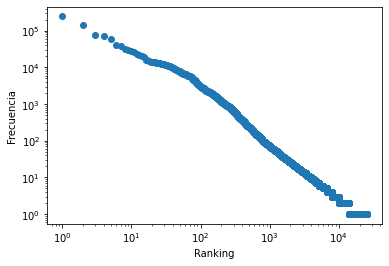

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.scatter(range(1,len(rslt.Frequency)+1),rslt.Frequency)
plt.xscale("log");plt.yscale("log")
plt.xlabel("Ranking"); plt.ylabel("Frecuencia");

In [ ]:
df_products['name']
comment_words=''
for i in df_products['name']: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    comment_words += " ".join(separate)+" "

In [ ]:
# Creating the Word Cloud
from wordcloud import WordCloud
final_wordcloud = WordCloud(width = 800, height = 800, 
    
                stopwords=stoplist, background_color="white", colormap="Dark2",collocations=True ,
                min_font_size = 10).generate(comment_words)

<function matplotlib.pyplot.show(*args, **kw)>

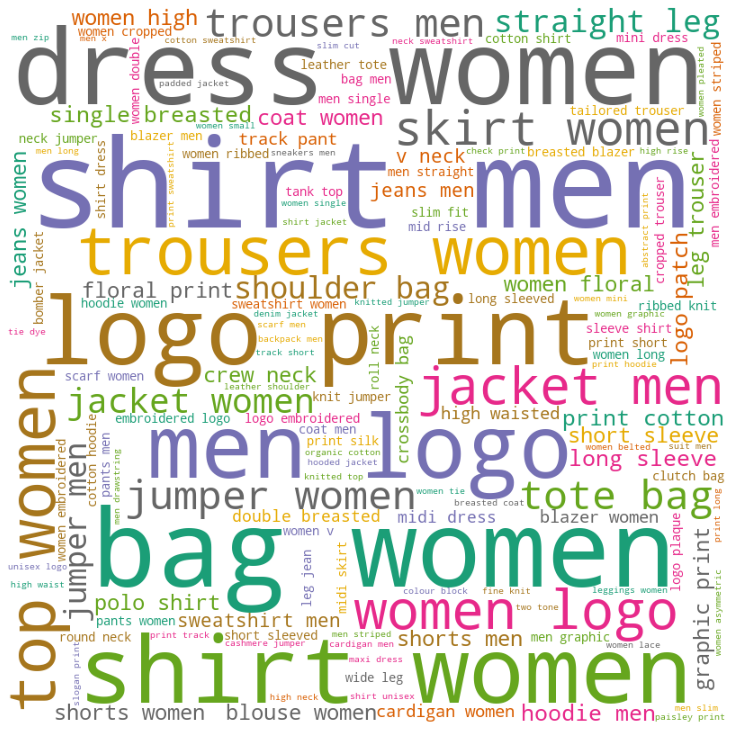

In [ ]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show

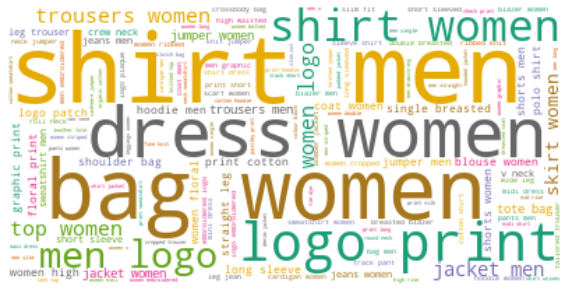

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def graph_words(column, data):
 
  data[column]=data[column].astype('str')
  text = "  ".join(i for i in data[column])
  wordcloud = WordCloud(stopwords=stoplist, background_color="white", colormap="Dark2",collocations=True).generate(text)
  plt.figure( figsize=(10,7))
  plt.imshow(wordcloud,interpolation="bilinear")
 
  plt.axis("off")
  plt.show()

graph_words('name',df_products)

In [ ]:
df_products['name']

0                x beatles intarsia knit coat unisex
1         cashmere blend long belted cardigan unisex
2         cashmere blend long belted cardigan unisex
3                      long cashmere cardigan unisex
4                tie dye print cashmere cardigan men
                             ...                    
398665                    wide leg denim jeans women
398666                    wide leg denim jeans women
398667                   cropped balloon jeans women
398668             high waisted wide leg jeans women
398669                high rise wide leg jeans women
Name: name, Length: 398670, dtype: object

In [ ]:
rslt.query("Frequency>5")

,Word,Frequency
0,women,245312
1,men,143208
2,shirt,76530
3,print,72031
4,logo,60038
...,...,...
5810,mihtry,6
5811,gritty,6
5812,crevice,6
5813,druid,6


In [ ]:
dict_freq_words=dict(zip(rslt.Word, rslt.Frequency.astype(int)))

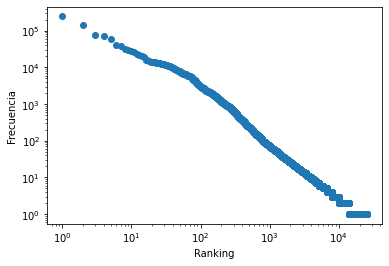

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.scatter(range(1,len(rslt.Frequency)+1),rslt.Frequency)
plt.xscale("log");plt.yscale("log")
plt.xlabel("Ranking"); plt.ylabel("Frecuencia");

In [ ]:
df_products['maximo']=0
i=0
for x in df_products.name:
  lst=(x.split(' '))
  max=0
  for w in lst:
    if len(w)>0:
     
     if dict_freq_words.get(w)!=None:
       if dict_freq_words.get(w)>max:

         max=dict_freq_words.get(w) 
         df_products.at[i, 'maximo'] = max
  i=i+1

Frecuencias de palabras

In [ ]:
rslt.query("Frequency>6")

,Word,Frequency
0,women,245312
1,men,143208
2,shirt,76530
3,print,72031
4,logo,60038
...,...,...
5181,concrete,7
5182,sabre,7
5183,fused,7
5184,fleury,7


Frecuencia máxima de palabras en cada producto 

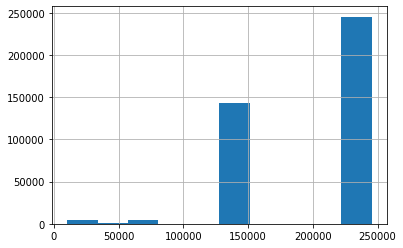

In [ ]:
df_products.maximo.hist()

In [ ]:
df_products.query("maximo==2")

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights,name,maximo


Frecuencia de Bigramas

In [ ]:
bigram_freq = {}
for doc in df_products['name']:
    cur_bigrams = set()
    words = doc.split(" ")
    bigrams = zip(words, words[1:])
    for bigram in bigrams:
        if bigram not in cur_bigrams: # Add bigram, but only once/doc
            cur_bigrams.add(bigram)
    for bigram in cur_bigrams:
        if bigram in bigram_freq:
            bigram_freq[bigram] += 1
        else:
            bigram_freq[bigram] = 1

result_df = pd.DataFrame(columns=["2_gram", "count"])
row_list = []
for bigram, freq in bigram_freq.items():
    row_list.append([bigram[0] + " " + bigram[1], freq])
#or i in range(len(row_list)):
#    print(i)
#    result_df.loc[i] = row_list[i]

#print(result_df)



In [ ]:

result_df=pd.DataFrame(row_list,columns=['Bigram','Frequency']).sort_values(by='Frequency',ascending=False)
wantedRows = result_df[result_df['Bigram'].str.split().str.len()==1].index 


In [ ]:
result_df

,Bigram,Frequency
186,shirt men,44433
1685,t shirt,40315
41377,bag women,33294
10418,dress women,30937
180,logo print,24316
...,...,...
71080,big flying,1
71079,flying brain,1
71078,bolo tie,1
71076,act tiger,1


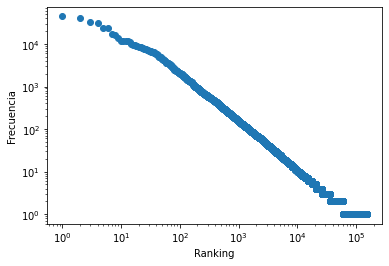

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.scatter(range(1,len(result_df.Frequency)+1),result_df.Frequency)
plt.xscale("log");plt.yscale("log")
plt.xlabel("Ranking"); plt.ylabel("Frecuencia");

In [ ]:

result_df=pd.DataFrame(row_list,columns=['Bigram','Frequency']).sort_values(by='Frequency',ascending=False)
wantedRows = result_df[result_df['Bigram'].str.split().str.len()==1].index 
result_df =  result_df.drop(wantedRows, axis = 0)

In [ ]:
fig = plt.figure(figsize=(20,12))
i=0

for l in df_products.product_family.unique(): #np.unique( km.labels_):
    print(l)
    break
    ax = fig.add_subplot(6,5,i+1)
    text = " ".join(cat for cat in df_products.query('product_family==@l').name)
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            background_color="salmon",
            colormap="Pastel1",
            collocations=False,
            stopwords=words

            ).generate(text)
        # Display the generated Word Cloud
    i=i+1
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.set_title(str(l))
    ax.axis("off")

Clothing


<Figure size 1440x864 with 0 Axes>

In [ ]:
result_df.describe()

,Frequency
count,149827.000000
mean,11.120512
std,268.446694
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,44433.000000


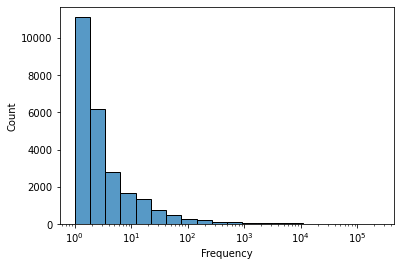

In [ ]:
import seaborn as sns
sns.histplot(data=rslt, x="Frequency",bins=20, log_scale=True)



In [ ]:
rslt.describe()

,Frequency
count,25247.000000
mean,81.823979
std,2086.580921
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,245312.000000


In [ ]:
result_df.describe()

,Frequency
count,149827.000000
mean,11.120512
std,268.446694
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,44433.000000


In [ ]:
 

df_products[df_products['name'].str.contains('long sleeves')].query('product_category=="Coats"')

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights,name,maximo


In [ ]:
df_long_sleeves=df_products[df_products['name'].str.contains('long sleeves')].groupby('product_category').product_category.count().reset_index(name='Cantidad').sort_values(by='Cantidad', ascending=False)

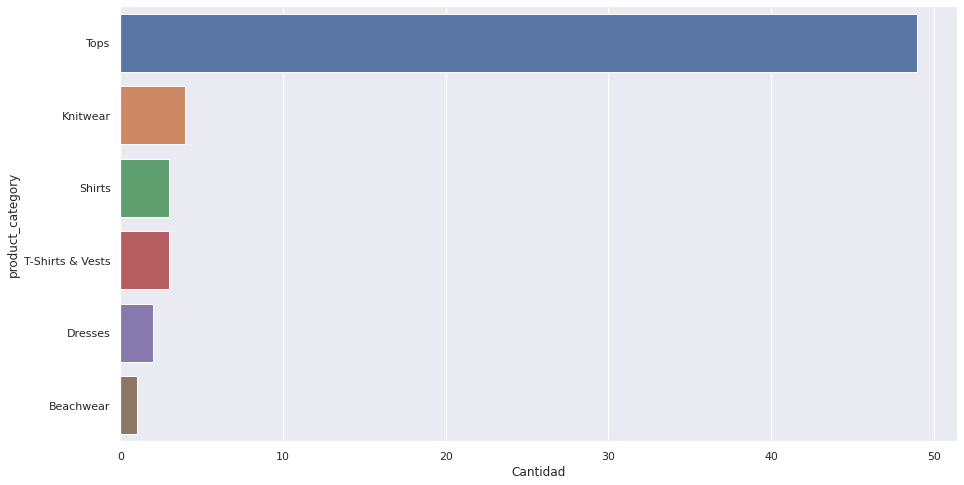

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(y="product_category", x="Cantidad", data=df_long_sleeves.head(1000))

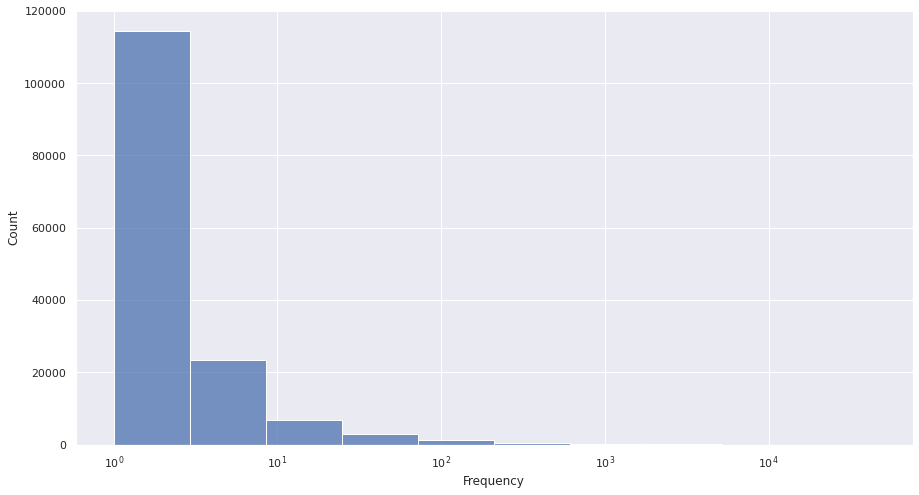

In [ ]:
import seaborn as sns
sns.histplot(data=result_df, x="Frequency", log_scale=True, bins=10)

Cantidad de productos por categoría

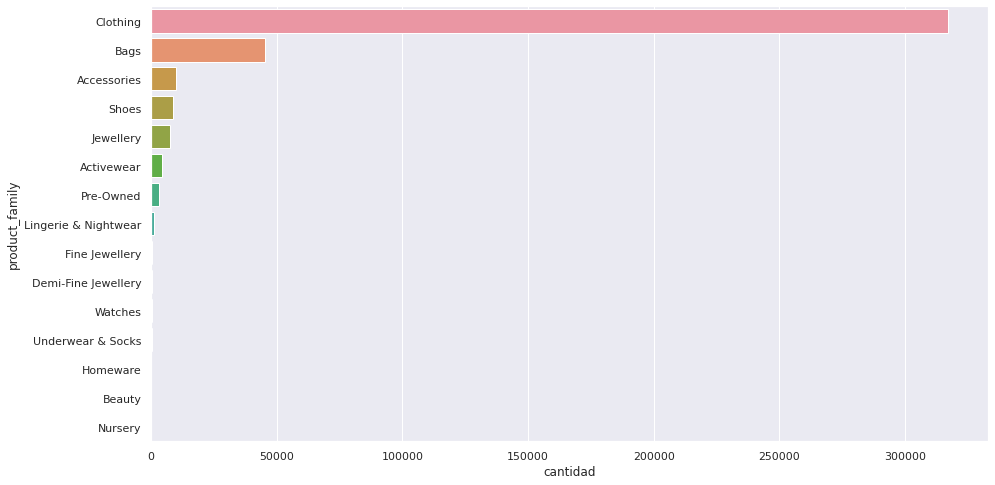

In [ ]:
import seaborn as sns

df_cant=df_products.groupby('product_family').product_family.count().reset_index(name="cantidad").sort_values(by='cantidad', ascending=False)
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(y="product_family", x="cantidad", data=df_cant.head(100))

Cantidad de productos por categoría

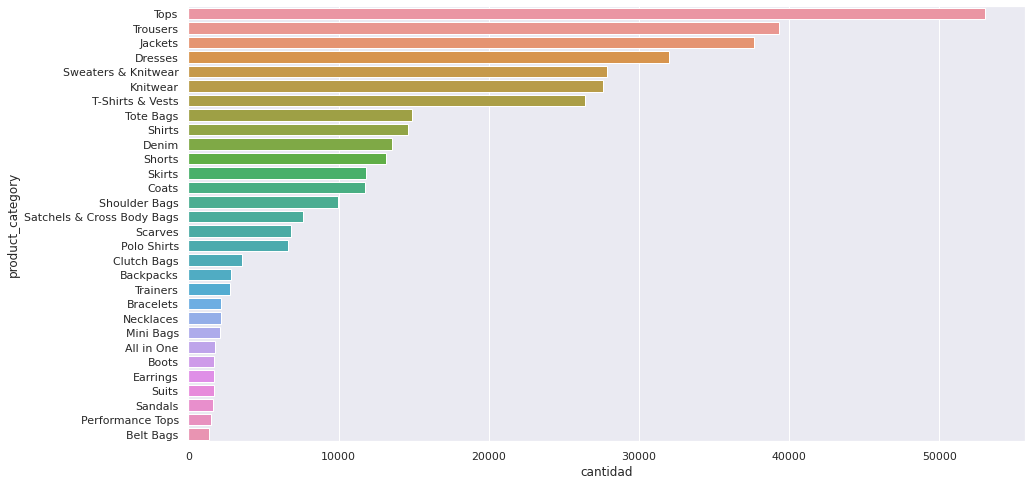

In [ ]:


df_cant=df_products.groupby('product_category').product_category.count().reset_index(name="cantidad").sort_values(by='cantidad', ascending=False)
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(y="product_category", x="cantidad", data=df_cant.head(30))



Cantidad de prouctos por subcategoría

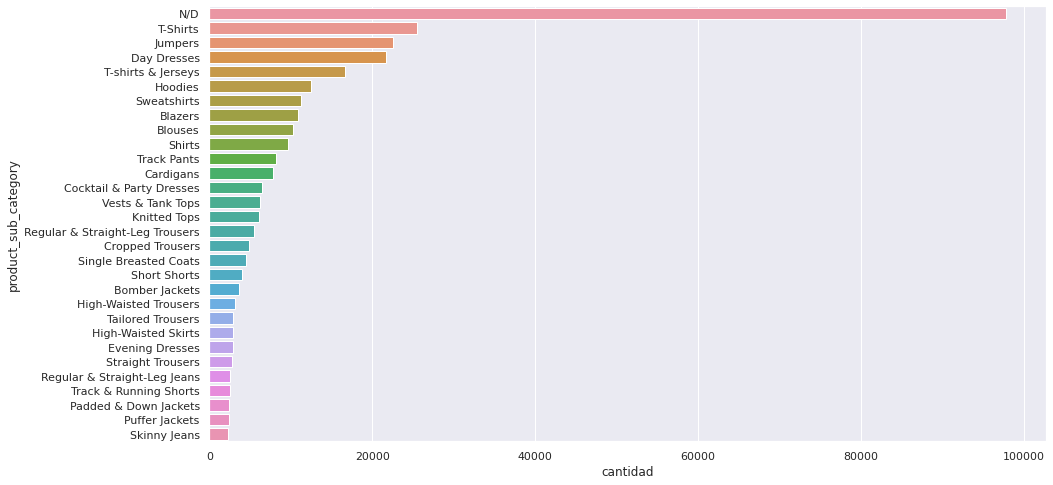

In [ ]:
df_cant=df_products.groupby('product_sub_category').product_sub_category.count().reset_index(name="cantidad").sort_values(by='cantidad', ascending=False)
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(y="product_sub_category", x="cantidad", data=df_cant.head(30))

In [ ]:

cant_nd=df_products.query("product_sub_category=='N/D'").groupby('product_category').product_category.count().reset_index(name="cantidad_ND").sort_values(by='cantidad_ND', ascending=False)

cant_all=df_products.groupby('product_category').product_category.count().reset_index(name="cantidad").sort_values(by='cantidad', ascending=False)

In [ ]:
cant_all=cant_all.merge(cant_nd, how='left', on='product_category').sort_values(by='cantidad', ascending=False)
cant_all['cantidad_ND']=cant_all['cantidad_ND'].fillna(0)
cant_all['cant_no_ND']=cant_all['cantidad']-cant_all['cantidad_ND']

In [ ]:
cant_all['cant_no_ND']

0      51864.0
1      38852.0
2      36812.0
3      31204.0
4      27728.0
        ...   
124        1.0
125        0.0
126        1.0
127        0.0
128        0.0
Name: cant_no_ND, Length: 129, dtype: float64

In [ ]:
cant_all

,product_category,cantidad,cantidad_ND,cant_no_ND
0,Tops,53072,1208.0,51864.0
1,Trousers,39294,442.0,38852.0
2,Jackets,37634,822.0,36812.0
3,Dresses,32012,808.0,31204.0
4,Sweaters & Knitwear,27869,141.0,27728.0
...,...,...,...,...
124,Makeup,1,0.0,1.0
125,Changing Bags,1,1.0,0.0
126,Skincare,1,0.0,1.0
127,Demi-Fine Body Jewellery,1,1.0,0.0


In [ ]:
cant_all

,product_category,cantidad,cantidad_ND,cant_no_ND
0,Tops,53072,1208.0,51864.0
1,Trousers,39294,442.0,38852.0
2,Jackets,37634,822.0,36812.0
3,Dresses,32012,808.0,31204.0
4,Sweaters & Knitwear,27869,141.0,27728.0
...,...,...,...,...
124,Makeup,1,0.0,1.0
125,Changing Bags,1,1.0,0.0
126,Skincare,1,0.0,1.0
127,Demi-Fine Body Jewellery,1,1.0,0.0


In [ ]:
cant_all=cant_all.sort_values(by='cantidad_ND', ascending=False)

In [ ]:
cant_all['porc_nd']= (cant_all['cantidad_ND'] / cant_all['cantidad']) *100


In [ ]:
cant_all.sort_values(by='porc_nd', ascending=False)

,product_category,cantidad,cantidad_ND,cant_no_ND,porc_nd
7,Tote Bags,14910,14910.0,0.0,100.0
80,Gloves,64,64.0,0.0,100.0
92,Ties,33,33.0,0.0,100.0
90,Camisoles & Corsets,35,35.0,0.0,100.0
91,Monk Shoes,35,35.0,0.0,100.0
...,...,...,...,...,...
123,Bath,1,0.0,1.0,0.0
124,Makeup,1,0.0,1.0,0.0
126,Skincare,1,0.0,1.0,0.0
107,Tableware,11,0.0,11.0,0.0


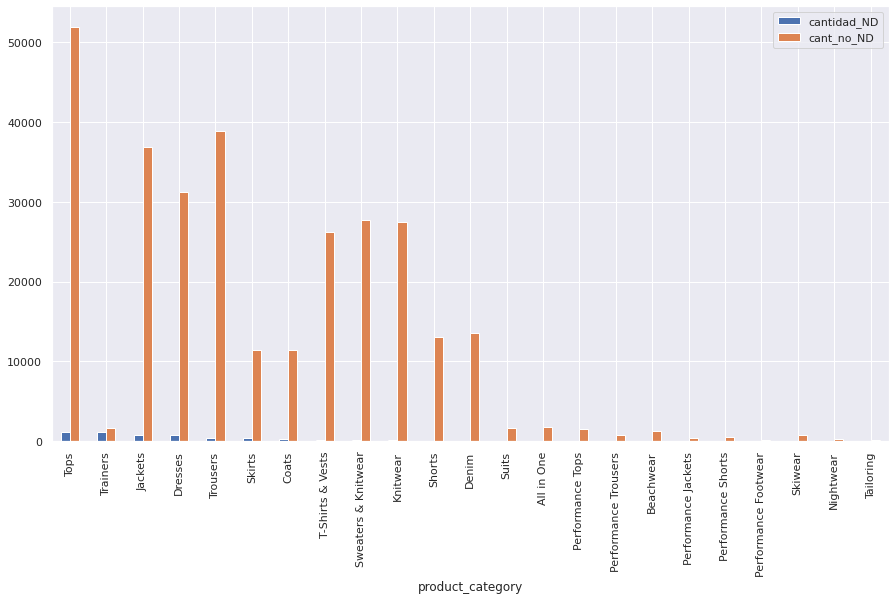

In [ ]:
cant_all.query('cant_no_ND>100')[['product_category', 'cantidad_ND',	'cant_no_ND']].plot(x='product_category', kind='bar')

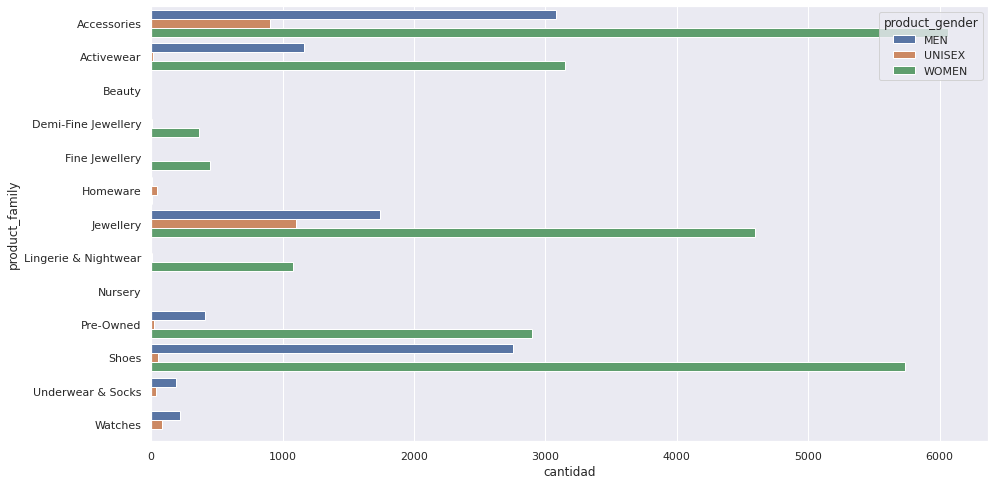

In [ ]:
import seaborn as sns
df_cant=pd.DataFrame(df_products.groupby(['product_family','product_gender']).count().reset_index())
df_cant=df_cant[['product_family','product_gender','product_id']]
df_cant.columns=['product_family','product_gender','cantidad']
sns.barplot(data=df_cant.query("product_family!='Clothing' and product_family!='Bags' "), y="product_family", x="cantidad", hue="product_gender")

In [ ]:
df_cant

,product_family,product_gender,cantidad
0,Accessories,MEN,3082
1,Accessories,UNISEX,905
2,Accessories,WOMEN,6065
3,Activewear,MEN,1162
4,Activewear,UNISEX,12
5,Activewear,WOMEN,3150
6,Bags,MEN,6447
7,Bags,UNISEX,1443
8,Bags,WOMEN,37446
9,Beauty,MEN,1


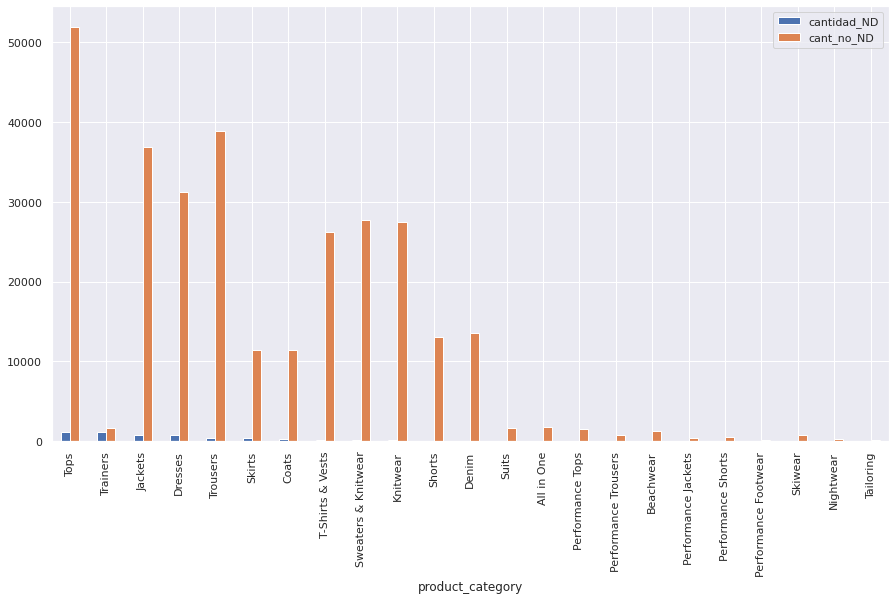

In [ ]:
cant_all.query('cant_no_ND>100')[['product_category', 'cantidad_ND',	'cant_no_ND']].plot(x='product_category', kind='bar')

In [ ]:

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier

In [ ]:
df_products['branch'] = df_products['product_family'] + '~' + df_products['product_category'] + '~' + df_products['product_sub_category']

In [ ]:
def clean_text(text):
  return text.strip()
def tokenizer(text):
    #return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return word_tokenize(text)


In [ ]:
db_cant_branch=pd.DataFrame(df_products.branch.value_counts().reset_index(name='cant'))

df_products_filtered=pd.merge(db_cant_branch.query("cant>500"),df_products, left_on='index',right_on='branch',how='inner')



In [ ]:
df_products_filtered

,index,cant,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights,name,maximo,branch
0,Clothing~T-Shirts & Vests~T-Shirts,25484,15643202,Clothing,T-Shirts & Vests,T-Shirts,WOMEN,BLACK,N/D,Vetements,[Cotton],logo-print cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",15/64/32/02/15643202.jpg,"[black, cotton, logo print at the chest, logo ...",logo print cotton t shirt women,245312,Clothing~T-Shirts & Vests~T-Shirts
1,Clothing~T-Shirts & Vests~T-Shirts,25484,16284376,Clothing,T-Shirts & Vests,T-Shirts,WOMEN,NEUTRALS,N/D,ATM Anthony Thomas Melillo,[Cotton],cotton-jersey scoop-neck T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/28/43/76/16284376.jpg,"[neutrals, cotton, scoop neck, jersey knit, st...",cotton jersey scoop neck t shirt women,245312,Clothing~T-Shirts & Vests~T-Shirts
2,Clothing~T-Shirts & Vests~T-Shirts,25484,16286834,Clothing,T-Shirts & Vests,T-Shirts,WOMEN,BLUE,N/D,adidas,[Cotton],x Pharrell Williams Basics embroidered logo T-...,"[{""attribute_name"":""Neckline"",""attribute_value...",16/28/68/34/16286834.jpg,"[night sky, cotton, signature trefoil logo det...",x pharrell williams basics embroidered logo t ...,245312,Clothing~T-Shirts & Vests~T-Shirts
3,Clothing~T-Shirts & Vests~T-Shirts,25484,16859087,Clothing,T-Shirts & Vests,T-Shirts,WOMEN,GREEN,N/D,ROTATE,[Organic Cotton],logo-print crew-neck T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/85/90/87/16859087.jpg,"[pale green, organic cotton, logo print to the...",logo print crew neck t shirt women,245312,Clothing~T-Shirts & Vests~T-Shirts
4,Clothing~T-Shirts & Vests~T-Shirts,25484,17992840,Clothing,T-Shirts & Vests,T-Shirts,WOMEN,BLACK,N/D,YVES SALOMON ARMY,[Organic Cotton],logo-print organic cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",17/99/28/40/17992840.jpg,"[black/white, organic cotton, logo print at th...",logo print organic cotton t shirt women,245312,Clothing~T-Shirts & Vests~T-Shirts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375108,Shoes~Mules~N/D,520,17294712,Shoes,Mules,N/D,WOMEN,BROWN,BLACK,AMINA MUADDI,"[Leather, Fabric, Rubber]",Gilda 95mm tiger print mules,"[{""attribute_name"":""Detail"",""attribute_values""...",17/29/47/12/17294712.jpg,"[brown, tiger print, crystal embellishment, br...",gilda tiger print mules women,245312,Shoes~Mules~N/D
375109,Shoes~Mules~N/D,520,17332312,Shoes,Mules,N/D,WOMEN,BLACK,N/D,GIVENCHY,"[Leather, Fabric]",Bedford flat mules,"[{""attribute_name"":""Detail"",""attribute_values""...",17/33/23/12/17332312.jpg,"[black, leather, signature 4G motif, round toe...",bedford flat mules women,245312,Shoes~Mules~N/D
375110,Shoes~Mules~N/D,520,17715766,Shoes,Mules,N/D,WOMEN,PINK,N/D,JACQUEMUS,"[Fabric, Leather]",Bagnu padded 80mm mules,"[{""attribute_name"":""Detail"",""attribute_values""...",17/71/57/66/17715766.jpg,"[pink, leather/fabric, asymmetric design, knot...",bagnu padded mules women,245312,Shoes~Mules~N/D
375111,Shoes~Mules~N/D,520,17783576,Shoes,Mules,N/D,WOMEN,PINK,N/D,VALENTINO GARAVANI,[Leather],Roman Stud 65mm leather mules,"[{""attribute_name"":""Detail"",""attribute_values""...",17/78/35/76/17783576.jpg,"[hot pink, leather, signature Roman Stud detai...",roman stud leather mules women,245312,Shoes~Mules~N/D


In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, _= train_test_split(
    df_products_filtered,
    df_products_filtered['branch'].values,
    test_size     = 0.3,
    stratify      = df_products_filtered['branch'].values,
    shuffle       = True
)

#test_set, val_set, _, _= train_test_split(
#    test_set,
#    test_set['branch'].values,
#    test_size     = 0.30,
#    shuffle       = False
#)

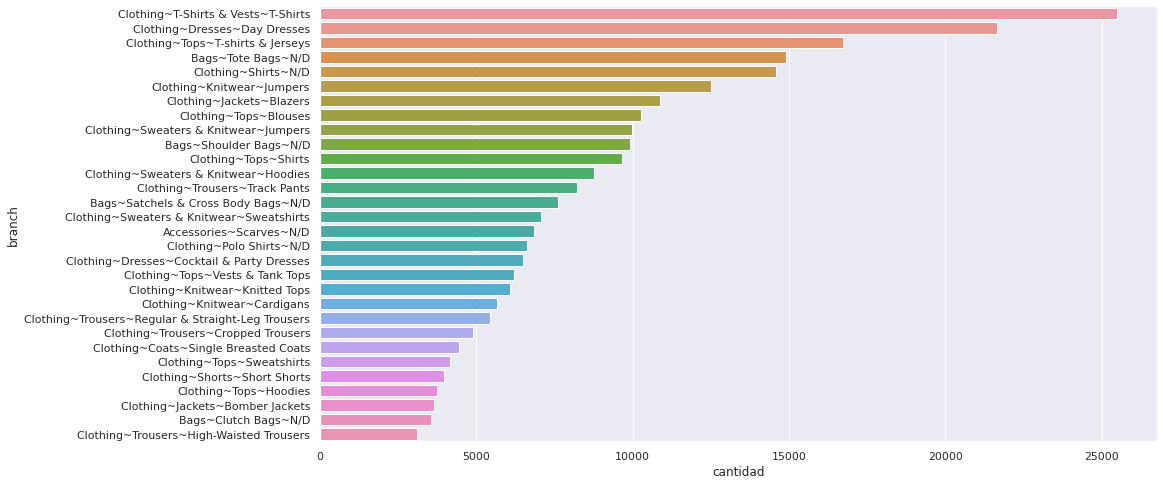

In [ ]:
df_cant=df_products_filtered.groupby('branch').product_sub_category.count().reset_index(name="cantidad").sort_values(by='cantidad', ascending=False)
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(y="branch", x="cantidad", data=df_cant.head(30))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition
from scipy.spatial.distance import cosine as cosine_distance
def get_topics_lsa(df, df_test, column,n_components=2):  


# Creación del objeto SVD
  svd = TruncatedSVD(n_components = n_components)
  count = CountVectorizer(min_df = 100, max_df = 0.90, stop_words = stoplist ,ngram_range=(1,3))
 
    # Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
  x_count = count.fit_transform(df[column])
  x_count_test=count.transform(df_test[column])

  print(count.get_feature_names_out())
  # Creamos el objeto tf-idf. Le decimos además que devuelva los
  # vectores documento con norma euclídea igual a 1 (norm = 'l2')
  tfidf = TfidfTransformer(norm = 'l2')

  # Creamos la matriz tf-idf a partir de la matriz de frecuencias
  x_tfidf = tfidf.fit_transform(x_count)
  x_tfidf_test=tfidf.transform(x_count_test)
  # Ajuste con los datos y descripción en el espacio reducido
  # Trabajamos con la matriz traspuesta
  x_svd = svd.fit_transform(x_tfidf.T)
  x_svd_test=svd.fit_transform(x_tfidf_test.T)
  # Dimensión de la matriz de datos en el espacio reducido
  print(x_svd.shape)
  
  vocabulary = {item: key for key, item in count.vocabulary_.items()}
  #vocabulary = {item: key for key, item in count.vocabulary_.items()} 
  #similarities = [1.00 - cosine_distance(x_svd[index_word], x_svd[i]) for i in range(x_svd.shape[0])]
  evr = svd.explained_variance_ratio_

  # Graficamos la fracción de varianza que aporta cada componente
  # y la información acumulada
  fig, ax = plt.subplots(1, 2, figsize = (12, 4))

  ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
  ax[0].set_ylabel('Fracción de varianza explicada')
  ax[0].set_xlabel('Número de valor singular')

  # Calculamos el acumulado con la función cumsum de numpy 
  varianza_acumulada = np.cumsum(evr)

  ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
  ax[1].set_ylabel('Fracción acumulada de varianza explicada')
  ax[1].set_xlabel('Cantidad de valores singulares')
 
  return x_svd,vocabulary,count, svd,x_count,x_tfidf,x_tfidf_test
  # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente

In [ ]:
from sklearn.metrics import f1_score
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
clf = MultinomialNB(alpha=1)

count_vect = CountVectorizer(preprocessor=clean_text, 
                             tokenizer=tokenizer, 
                             min_df=70,
                             stop_words=stoplist,
                             ngram_range=(1,2),
                             max_df = 0.90)
X_train_ngrams = count_vect.fit_transform(train_set.name) # cuenta frecuencia de tokens y define el diccionario


print("numero de features=",X_train_ngrams.shape[1])
clf.fit(X_train_ngrams, train_set.branch)
f1_score(test_set.branch, clf.predict(count_vect.transform(test_set.name)), average='macro')
#scores_cv_ngrams = cross_val_score(clf,X_train_ngrams, train_set.branch,cv = 10, scoring='f1_macro')
#print("f-score=",round(scores_cv_ngrams.mean(),4)," ( sd =",round(scores_cv_ngrams.std(),4),")")z

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


numero de features= 2084


0.7339232737321519

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report as cr
y_pred=clf.predict(count_vect.transform(test_set.name))
metrics=(cr(test_set.branch, y_pred, labels=test_set.branch.unique()))



In [ ]:
print(metrics)

                                                      precision    recall  f1-score   support

                               Clothing~Tops~Hoodies       0.88      0.92      0.90      1126
              Clothing~Shorts~Track & Running Shorts       0.81      0.84      0.82       749
                Clothing~Sweaters & Knitwear~Hoodies       0.95      0.96      0.95      2635
                      Clothing~Knitwear~Knitted Tops       0.67      0.70      0.68      1830
                   Clothing~Coats~Trench & Raincoats       0.79      0.78      0.79       406
                                 Clothing~Shirts~N/D       0.76      0.77      0.77      4381
                  Clothing~Trousers~Cropped Trousers       0.73      0.67      0.70      1473
                               Clothing~Tops~Blouses       0.84      0.77      0.80      3080
                       Clothing~Skirts~A-Line Skirts       0.50      0.54      0.52       676
                                  Bags~Belt Bags~N/D       

In [ ]:
def pandas_classification_report(y_true, y_pred,labels):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred ,labels=labels)
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted',labels=labels))

    metrics_sum_index = ['precision', 'recall', 'f1', 'support']
    class_report_df = pd.DataFrame(
       
        list(metrics_summary),
        index=metrics_sum_index
        )
   
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    
    class_report_df['avg / total'] = avg

    return class_report_df.T

results=pandas_classification_report(test_set.branch, y_pred,labels=test_set.branch.unique())

In [ ]:
l=(list(test_set.branch.unique()))
l.append('Total')

results['label']=l

In [ ]:

results.sort_values(by='f1',ascending=False).query('f1<0.69')[['label','precision',	'recall',	'f1'	,'support'	]]

,label,precision,recall,f1,support
101,Clothing~Tops~Polo Tops,0.663366,0.716578,0.688946,187.0
3,Clothing~Knitwear~Knitted Tops,0.667016,0.696175,0.681283,1830.0
90,Clothing~Denim~Cropped Jeans,0.670588,0.672170,0.671378,424.0
22,Clothing~Trousers~Tailored Trousers,0.662921,0.671217,0.667044,879.0
48,Clothing~Trousers~Wide-Leg Trousers,0.729927,0.613497,0.666667,163.0
82,Clothing~T-Shirts & Vests~Vests & Tanks,0.542424,0.856459,0.664193,209.0
23,Clothing~Trousers~Tapered Trousers,0.704918,0.617594,0.658373,557.0
109,Clothing~Jackets~Hooded Jackets,0.634744,0.652174,0.643341,437.0
36,Bags~Mini Bags~N/D,0.671353,0.596875,0.631927,640.0
47,Clothing~Trousers~Flared Trousers,0.653025,0.578864,0.613712,634.0


In [ ]:
results.sort_values(by='f1',ascending=False)[['label','precision',	'recall',	'f1'	,'support'	]]

,label,precision,recall,f1,support
66,Shoes~Boots~N/D,0.988281,0.988281,0.988281,512.0
81,Jewellery~Rings~N/D,0.986622,0.989933,0.988275,298.0
98,Shoes~Trainers~Low-Tops,0.997494,0.968370,0.982716,411.0
46,Accessories~Scarves~N/D,0.981809,0.970831,0.976289,2057.0
60,Jewellery~Necklaces~N/D,0.976636,0.975117,0.975875,643.0
...,...,...,...,...,...
58,Clothing~Skirts~Full Skirts,0.492188,0.268085,0.347107,235.0
73,Pre-Owned~Jackets~N/D,0.640000,0.227488,0.335664,211.0
79,Clothing~Jackets~Oversized Jackets,0.383333,0.262357,0.311512,263.0
105,Pre-Owned~Dresses~N/D,0.625000,0.190217,0.291667,184.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


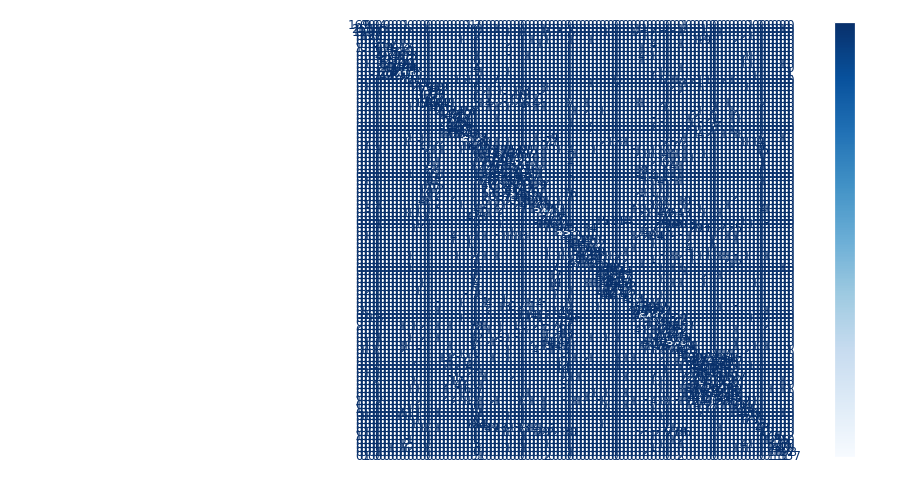

<Figure size 2880x2016 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(test_set.branch,y_pred, labels=test_set.branch.unique())
cm


import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'white'
matrix = plot_confusion_matrix( clf, count_vect.transform(test_set.name),test_set.branch , cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.figure(figsize = (40,28))
plt.show()

In [ ]:
pd.DataFrame(cm, index=test_set.branch.unique())

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
Clothing~Tops~Hoodies,1035,0,41,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clothing~Shorts~Track & Running Shorts,0,626,1,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
Clothing~Sweaters & Knitwear~Hoodies,15,1,2539,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,13,0
Clothing~Knitwear~Knitted Tops,19,0,0,1274,0,0,0,35,0,0,...,37,0,0,2,0,0,0,0,0,0
Clothing~Coats~Trench & Raincoats,1,0,0,0,316,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Clothing~Shorts~Cargo Shorts,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,145,0,0,0,0
Bags~Bucket Bags~N/D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,283,0,0,0
Clothing~Trousers~Palazzo Pants,0,0,0,0,0,0,23,0,0,0,...,0,3,0,0,0,0,0,249,0,0
Clothing~Jackets~Hooded Jackets,1,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,285,0


In [ ]:
classes=len(test_set.branch.unique())+1

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition
from scipy.spatial.distance import cosine as cosine_distance
def get_topics_lsa(df, df_test, column,n_components=2):  


# Creación del objeto SVD
  svd = TruncatedSVD(n_components = n_components)
  count = CountVectorizer(min_df = 100, max_df = 0.90, stop_words = words ,ngram_range=(1, 1))
 
    # Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
  x_count = count.fit_transform(df[column])
  x_count_test = count.transform(df_test[column])
  # Creamos el objeto tf-idf. Le decimos además que devuelva los
  # vectores documento con norma euclídea igual a 1 (norm = 'l2')
  tfidf = TfidfTransformer(norm = 'l2')

  # Creamos la matriz tf-idf a partir de la matriz de frecuencias
  x_tfidf = tfidf.fit_transform(x_count)

  x_tfidf_test = tfidf.transform(x_count_test)
  # Ajuste con los datos y descripción en el espacio reducido
  # Trabajamos con la matriz traspuesta
  x_svd = svd.fit_transform(x_tfidf.T)
  x_svd_test = svd.fit_transform(x_tfidf_test.T)

  # Dimensión de la matriz de datos en el espacio reducido
  
  vocabulary = {item: key for key, item in count.vocabulary_.items()}
  #vocabulary = {item: key for key, item in count.vocabulary_.items()} 
  #similarities = [1.00 - cosine_distance(x_svd[index_word], x_svd[i]) for i in range(x_svd.shape[0])]
  evr = svd.explained_variance_ratio_

  # Graficamos la fracción de varianza que aporta cada componente
  # y la información acumulada
  fig, ax = plt.subplots(1, 2, figsize = (12, 4))

  ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
  ax[0].set_ylabel('Fracción de varianza explicada')
  ax[0].set_xlabel('Número de valor singular')

  # Calculamos el acumulado con la función cumsum de numpy 
  varianza_acumulada = np.cumsum(evr)

  ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
  ax[1].set_ylabel('Fracción acumulada de varianza explicada')
  ax[1].set_xlabel('Cantidad de valores singulares')
 
  return x_svd,vocabulary,count, svd,x_count,x_tfidf,x_tfidf_test,x_svd_test
  # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
  

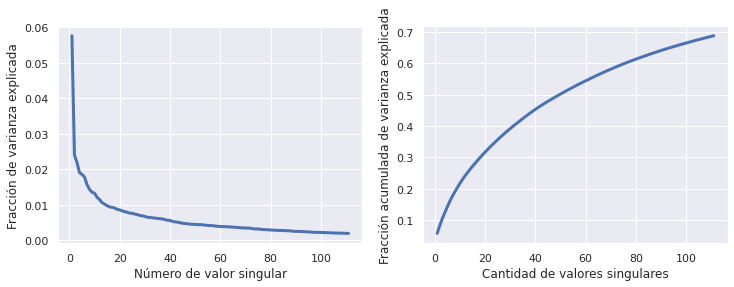

In [ ]:
x_svd,vocab_ing, count,svd,x_count,x_tfidf,x_tfidf_test,x_svd_test=get_topics_lsa(train_set,test_set, 'name',n_components=111)

In [ ]:
d_in=x_count.shape
test_set.branch.unique()
y=np.arange(1, 112, 1, dtype=int)
test_set.branch

252273                        Clothing~Tops~Hoodies
280230       Clothing~Shorts~Track & Running Shorts
162806         Clothing~Sweaters & Knitwear~Hoodies
217907               Clothing~Knitwear~Knitted Tops
214548               Clothing~Knitwear~Knitted Tops
                            ...                    
203387    Clothing~Dresses~Cocktail & Party Dresses
16174            Clothing~T-Shirts & Vests~T-Shirts
374919                              Shoes~Mules~N/D
147106                         Clothing~Tops~Shirts
268794          Clothing~Skirts~High-Waisted Skirts
Name: branch, Length: 112534, dtype: object

In [ ]:
del(df_categorias)
df_categorias=pd.DataFrame(df_products_filtered.branch.unique(),columns=['categoria']).reset_index()

df_categorias

train_set=pd.merge(df_categorias,train_set, right_on='branch',left_on='categoria')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_y'} in the result is deprecated and will raise a MergeError in a future version.
  


In [ ]:
train_set.index_x

,index_x,categoria,index_y,cant,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights,name,maximo,branch
0,0,Clothing~T-Shirts & Vests~T-Shirts,Clothing~T-Shirts & Vests~T-Shirts,25484,16981428,Clothing,T-Shirts & Vests,T-Shirts,MEN,WHITE,N/D,A-COLD-WALL*,[Cotton],logo patch cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/98/14/28/16981428.jpg,"[off white, cotton, crew neck, drop shoulder, ...",logo patch cotton t shirt men,143208,Clothing~T-Shirts & Vests~T-Shirts
1,0,Clothing~T-Shirts & Vests~T-Shirts,Clothing~T-Shirts & Vests~T-Shirts,25484,13193083,Clothing,T-Shirts & Vests,T-Shirts,MEN,WHITE,N/D,WTAPS,[Cotton],pocket cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",13/19/30/83/13193083.jpg,,pocket cotton t shirt men,143208,Clothing~T-Shirts & Vests~T-Shirts
2,0,Clothing~T-Shirts & Vests~T-Shirts,Clothing~T-Shirts & Vests~T-Shirts,25484,16651490,Clothing,T-Shirts & Vests,T-Shirts,MEN,BLACK,N/D,COMME DES GARÇONS,[Cotton],logo-print T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/65/14/90/16651490.jpg,"[black, cotton, logo print to the front, round...",logo print t shirt men,143208,Clothing~T-Shirts & Vests~T-Shirts
3,0,Clothing~T-Shirts & Vests~T-Shirts,Clothing~T-Shirts & Vests~T-Shirts,25484,16738791,Clothing,T-Shirts & Vests,T-Shirts,MEN,BLUE,N/D,STONE ISLAND,[Cotton],embroidered logo cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/73/87/91/16738791.jpg,"[light blue, cotton, round neck, short sleeves...",embroidered logo cotton t shirt men,143208,Clothing~T-Shirts & Vests~T-Shirts
4,0,Clothing~T-Shirts & Vests~T-Shirts,Clothing~T-Shirts & Vests~T-Shirts,25484,16929245,Clothing,T-Shirts & Vests,T-Shirts,MEN,BLACK,N/D,DIESEL,[BCI Cotton],T-Just-B72 BCI cotton T-shirt,"[{""attribute_name"":""Neckline"",""attribute_value...",16/92/92/45/16929245.jpg,"[black/red, BCI cotton, embroidered slogan, ro...",t just bci cotton t shirt men,143208,Clothing~T-Shirts & Vests~T-Shirts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262574,110,Shoes~Mules~N/D,Shoes~Mules~N/D,520,16263358,Shoes,Mules,N/D,WOMEN,PINK,N/D,MACH & MACH,"[Leather, Satin]",double bow 65mm mules,None,16/26/33/58/16263358.jpg,"[pink, satin, bow detailing, crystal embellish...",double bow mules women,245312,Shoes~Mules~N/D
262575,110,Shoes~Mules~N/D,Shoes~Mules~N/D,520,13598262,Shoes,Mules,N/D,WOMEN,YELLOW,N/D,Studio Chofakian,[Leather],leather mules,None,13/59/82/62/13598262.jpg,,leather mules women,245312,Shoes~Mules~N/D
262576,110,Shoes~Mules~N/D,Shoes~Mules~N/D,520,16264269,Shoes,Mules,N/D,WOMEN,NEUTRALS,N/D,MANOLO BLAHNIK,[Leather],Ballerimu pointed-toe mules,"[{""attribute_name"":""Detail"",""attribute_values""...",16/26/42/69/16264269.jpg,"[beige, leather, pointed toe, bow detailing, s...",ballerimu pointed toe mules women,245312,Shoes~Mules~N/D
262577,110,Shoes~Mules~N/D,Shoes~Mules~N/D,520,14955905,Shoes,Mules,N/D,WOMEN,PINK,N/D,MANOLO BLAHNIK,"[Satin, Leather]",Hangisi 70mm crystal-embellished satin mules,"[{""attribute_name"":""Detail"",""attribute_values""...",14/95/59/05/14955905.jpg,"[fuchsia-pink, satin , mid heel, pointed toe, ...",hangisi crystal embellished satin mules women,245312,Shoes~Mules~N/D


In [ ]:
np.array(train_set.index_x)

array([  0,   0,   0, ..., 110, 110, 110])